In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
#%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
import sys, os

import scipy
from scipy import signal
sys.path.append('C:/Users/alexp/OneDrive - Αριστοτέλειο Πανεπιστήμιο Θεσσαλονίκης/διδακτορικο/New folder')

import warnings
import math
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
#from tigramite.independence_tests import GPDC, CMIknn, CMIsymb
from tigramite.independence_tests.parcorr import ParCorr

from tigramite.models import LinearMediation, Prediction

import networkx as nx


In [2]:
# Setting the number of years and time cycle according to our data
n_years = 20
time_cycle = 52  # 52 weeks in a year

In [3]:
# Load data
data = pd.read_excel("C:/Users/alexp/OneDrive - Αριστοτέλειο Πανεπιστήμιο Θεσσαλονίκης/διδακτορικο/New folder/daily_data/daily_maxT/daily_maxT_telec.xlsx")

In [4]:
# Ensure the data has the correct datetime index
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('Date', inplace=True)

In [5]:
# Resample data to weekly average
weekly_data_df = data.resample('W').mean()

In [6]:
# Extract the resampled data
Tmax_B15 = weekly_data_df['maxT_B15'].values
Tmax_B16 = weekly_data_df['maxT_B16'].values
Tmax_B18 = weekly_data_df['maxT_B18'].values
Tmax_B19 = weekly_data_df['maxT_B19'].values

NAO = weekly_data_df['NAO'].values
AO = weekly_data_df['AO'].values
MOI = weekly_data_df['MOI'].values
RMM_MJO = weekly_data_df['RMM_MJO'].values
PNA = weekly_data_df['PNA'].values

In [7]:
# Detrend the data
for j in range(time_cycle):
    Tmax_B15[j::time_cycle] = signal.detrend(Tmax_B15[j::time_cycle], axis=0)
    Tmax_B16[j::time_cycle] = signal.detrend(Tmax_B16[j::time_cycle], axis=0)
    Tmax_B18[j::time_cycle] = signal.detrend(Tmax_B18[j::time_cycle], axis=0)
    Tmax_B19[j::time_cycle] = signal.detrend(Tmax_B19[j::time_cycle], axis=0)

    NAO[j::time_cycle] = signal.detrend(NAO[j::time_cycle], axis=0)
    AO[j::time_cycle] = signal.detrend(AO[j::time_cycle], axis=0)
    MOI[j::time_cycle] = signal.detrend(MOI[j::time_cycle], axis=0)
    RMM_MJO[j::time_cycle] = signal.detrend(RMM_MJO[j::time_cycle], axis=0)
    PNA[j::time_cycle] = signal.detrend(PNA[j::time_cycle], axis=0)

In [8]:
# Calculate anomalies
for i in range(time_cycle):
    Tmax_B15[i::time_cycle] = (Tmax_B15[i::time_cycle] - np.mean(Tmax_B15[:int(time_cycle*n_years)][i::time_cycle], axis=0))
    Tmax_B16[i::time_cycle] = (Tmax_B16[i::time_cycle] - np.mean(Tmax_B16[:int(time_cycle*n_years)][i::time_cycle], axis=0))
    Tmax_B18[i::time_cycle] = (Tmax_B18[i::time_cycle] - np.mean(Tmax_B18[:int(time_cycle*n_years)][i::time_cycle], axis=0))
    Tmax_B19[i::time_cycle] = (Tmax_B19[i::time_cycle] - np.mean(Tmax_B19[:int(time_cycle*n_years)][i::time_cycle], axis=0))

    NAO[i::time_cycle] = (NAO[i::time_cycle] - np.mean(NAO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
    AO[i::time_cycle] = (AO[i::time_cycle] - np.mean(AO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
    MOI[i::time_cycle] = (MOI[i::time_cycle] - np.mean(MOI[:int(time_cycle*n_years)][i::time_cycle], axis=0))
    RMM_MJO[i::time_cycle] = (RMM_MJO[i::time_cycle] - np.mean(RMM_MJO[:int(time_cycle*n_years)][i::time_cycle], axis=0))
    PNA[i::time_cycle] = (PNA[i::time_cycle] - np.mean(PNA[:int(time_cycle*n_years)][i::time_cycle], axis=0))


In [45]:

# Stack the data to create the final array for analysis
fulldata = np.vstack((Tmax_B15/np.std(Tmax_B15), 
                      NAO/np.std(NAO),
                      MOI/np.std(MOI),
                      RMM_MJO/np.std(RMM_MJO))).T

var_names = ['Tmax_CY', 'NAO', 'MOI', 'RMM_MJO']

In [46]:
# Get the weekly date range to match the resampled data
weekly_date_range = weekly_data_df.index

In [47]:
# Create seasonal masks for the weekly data
jja_mask = ((weekly_date_range.month == 6) | (weekly_date_range.month == 7) | (weekly_date_range.month == 8))
ndj_mask = ((weekly_date_range.month == 11) | (weekly_date_range.month == 12) | (weekly_date_range.month == 1))
mam_mask = ((weekly_date_range.month == 3) | (weekly_date_range.month == 4) | (weekly_date_range.month == 5))
son_mask = ((weekly_date_range.month == 9) | (weekly_date_range.month == 10) | (weekly_date_range.month == 11))
# Create seasonal masks for the weekly data
hot_mask = ((weekly_date_range.month == 5) | (weekly_date_range.month == 6)| (weekly_date_range.month == 7) | (weekly_date_range.month == 8)| (weekly_date_range.month == 9))

In [48]:

# Combine masks if needed (example: mask data for NDJ season)
data_mask = np.ones(fulldata.shape, dtype=bool)
data_mask[jja_mask, :] = False   #Here we choose the mask

print(data_mask[:52, 0])  # Print to verify the first 52 weeks of the mask


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: ylabel='Tmax_CY'>, <Axes: ylabel='NAO'>,
        <Axes: ylabel='MOI'>, <Axes: ylabel='RMM_MJO'>], dtype=object))

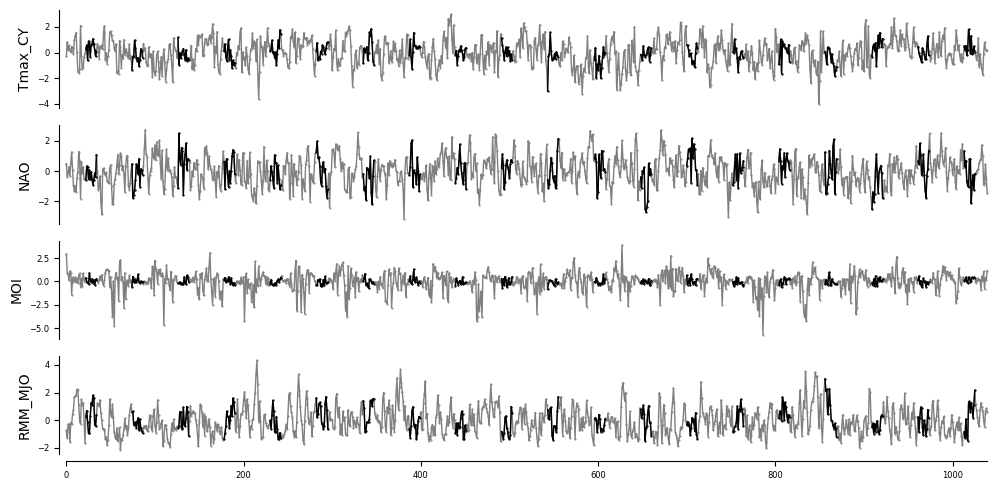

In [49]:
# Initialize dataframe object (needed for tigramite functions)
dataframe = pp.DataFrame(fulldata, datatime=np.arange(len(fulldata)), var_names=var_names, mask=data_mask)

# Plot the time series to verify that masking is correct
tp.plot_timeseries(dataframe, figsize=(10, 5), grey_masked_samples='data')


In [50]:
##### PCMCI
parcorr = ParCorr(significance='analytic', 
                  mask_type='y', 
                  verbosity=4)

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    #selected_variables=None,
    verbosity=4)

#results = pcmci.run_pc_stable(tau_max=6, pc_alpha=0.05)
tau_min = 1
tau_max = 4
results = pcmci.run_pcmci(tau_max=tau_max,tau_min=tau_min, pc_alpha = None)#[0.001, 0.01,0.05, 0.1, 0.2])#None)
# put also tau_min if you need

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
alpha_level_v = 0.05

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
         
    
        val_matrix = results['val_matrix'],
        alpha_level = alpha_level_v)

graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.05,
            tau_min=tau_min, tau_max=tau_max, 
           #selected_links=None
            )
results['graph'] = graph 



# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic
mask_type = y

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 4
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Variable Tmax_CY

Iterating through pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:

# pc_alpha = 0.05 (1/6):

Testing condition sets of dimension 0:

    Link (Tmax_CY -1) -?> Tmax_CY (1/16):
            Constructed array of shape (2, 262) from
            X = [(0, -1)]
            Y = [(0, 0)]
            Z = []
            extraZ = []
            with masked samples in y removed
        val =  0.354 | pval = 0.00000 | dependent = True 
    Subset 0: () gives pval = 0.00000 / val =  0.354
    No conditions of dimension 0 left.

    Link (Tmax_CY -2) -?> Tmax_CY (2/16):
            Constructed array of shape (2, 262) from
            X = [(0, -2)]
  

In [51]:
#sig = pcmci.return_significant_links(
#                        pq_matrix=q_matrix,
#                        val_matrix=results['val_matrix'], 
#                        alpha_level=alpha_level_v)

# Remove some links link_matrix[i, j, tau] is link  i -- tau --> j
# link_matrix[[1,2,3,4,], :, :] = False

#all_parents = sig['link_dict']
all_parents = pcmci.return_parents_dict(graph, val_matrix=results['val_matrix'], include_lagzero_parents=False)
print(all_parents)
link_matrix = graph
#link_matrix = sig['link_matrix']
med = LinearMediation(dataframe=dataframe,            

            mask_type = 'y',
            data_transform = None)
med.fit_model(all_parents = all_parents, tau_max=tau_max)             
Links = med.get_val_matrix()
pcmci.print_significant_links(
        p_matrix = q_matrix, 
        #q_matrix = q_matrix,
    
        val_matrix = Links,
        alpha_level = alpha_level_v)

{0: [(0, -1), (2, -1), (1, -1), (3, -2)], 1: [(1, -1), (3, -2)], 2: [(0, -1), (1, -3)], 3: [(3, -1), (3, -2), (1, -3)]}

## Significant links at alpha = 0.05:

    Variable Tmax_CY has 4 link(s):
        (Tmax_CY -1): pval = 0.00001 | val =  0.348
        (MOI -1): pval = 0.02833 | val = -0.316
        (NAO -1): pval = 0.03122 | val = -0.131
        (RMM_MJO -2): pval = 0.04679 | val = -0.088

    Variable NAO has 2 link(s):
        (NAO -1): pval = 0.00000 | val =  0.331
        (RMM_MJO -2): pval = 0.04679 | val = -0.173

    Variable MOI has 2 link(s):
        (Tmax_CY -1): pval = 0.00345 | val =  0.103
        (NAO -3): pval = 0.04679 | val =  0.058

    Variable RMM_MJO has 3 link(s):
        (RMM_MJO -1): pval = 0.00000 | val =  0.617
        (RMM_MJO -2): pval = 0.02317 | val = -0.120
        (NAO -3): pval = 0.02317 | val = -0.109


In [52]:
#sig = pcmci.return_significant_links(
#                        pq_matrix=q_matrix,
#                        val_matrix=results['val_matrix'], 
#                        alpha_level=alpha_level_v)

# Remove some links link_matrix[i, j, tau] is link  i -- tau --> j
# link_matrix[[1,2,3,4,], :, :] = False

#all_parents = sig['link_dict']
#link_matrix = sig['link_matrix']

# print all_parents
# print all_parents
# print link_matrix

# beta coefficients
#med = LinearMediation(dataframe=dataframe,           
#
#           mask_type ='y',
#            data_transform = None)   # False or None for sklearn.preprocessing.StandardScaler = 

#med.fit_model(all_parents=all_parents, tau_max= tau_max)

(<Figure size 600x400 with 1 Axes>, <Axes: >)

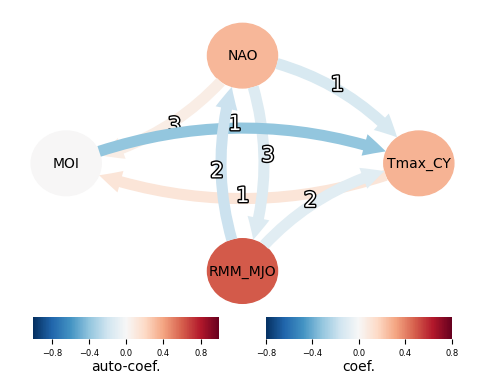

In [53]:
# Plot graph with link color given by linear regression coefficients
val_matrix = med.get_val_matrix()
#print(val_matrix)
tp.plot_graph(
    val_matrix=val_matrix,
    #link_matrix=link_matrix,
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='coef.',
    node_colorbar_label='auto-coef.',
    
    figsize = [6,4],
    vmin_edges = -0.8,
    vmax_edges = 0.8,
    #vmin_nodes = -1.0,
    #vmax_nodes = 1.,
    node_size  =0.6,
    #arrow_linewidth  = 12,
    #arrowhead_size = 20,
    #cmap_nodes = 'RdBu_r',
    #edge_ticks = 0.2,
    #node_ticks = 0.25,
    #alpha = 1,
    #node_pos = {'x':(0.9,0.5,0.1,0.9,0.7,0.5), 'y':(0.7,1,0.7,0.0,0.25,0.5)},#node_pos  = None,
    #[  'MT rain', 'NAO', 'CGTI', 'EOF2', 'EOF1']
    #node_pos = {'x':(0.5,0.3, 0.7), 'y':(0.2,0.65, 1)},#node_pos  = None,
    #[  'MT rain', 'CGTI', 'EOF2']
    node_label_size = 10,
    link_label_fontsize  = 15,
     )



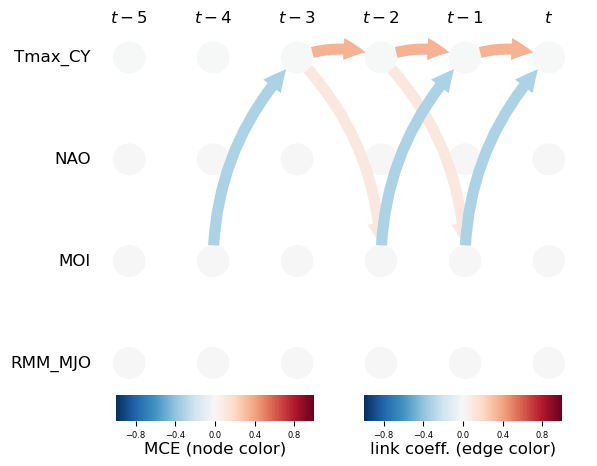

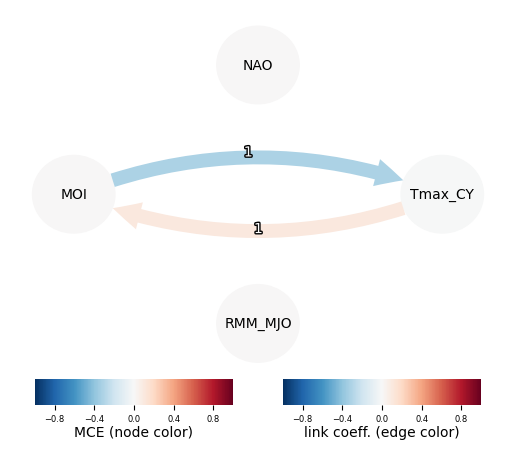

In [54]:
i=2; tau=4; j=0
graph_data = med.get_mediation_graph_data(i=i, tau=tau, j=j)

# Plot mediation graph showing only links for causal paths from (i, -tau) --> j (receiving the final link)
# The link color are the path coefficients and the node color the Mediated Causal Effect (MCE) of the variable
tp.plot_mediation_time_series_graph(
    var_names=var_names,
        path_node_array=graph_data['path_node_array'],
    tsg_path_val_matrix=graph_data['tsg_path_val_matrix']
    )

tp.plot_mediation_graph(
                    var_names=var_names,
                    node_size  =0.6,
                    path_val_matrix=graph_data['path_val_matrix'], 
                    path_node_array=graph_data['path_node_array'],
                    )


